<a href="https://www.kaggle.com/code/podturkinalex/appa-real-face-age?scriptVersionId=101440185" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Предсказание возраста клиентов по фотографии

**Цель**
* Определить возраст человека по фотографии.

**Задача**
* Построить регрессионную модель для определения возраста клиентов по изображениям.
* В качестве метрика качества модели выбрана `MAE`, значение которой должно быть не больше 8.

**Описание данных**
* Данные взяты с сайта `ChaLearn Looking at People`: https://chalearnlap.cvc.uab.cat/dataset/26/description/. 
* Таблица `labels.csv` содержит две колонки с названием файла изображения `file_name` и возраста человека `real_age`.

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import keras
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.resnet import ResNet50
import warnings
warnings.filterwarnings('ignore')


In [28]:
# Загрузим директорию
os.listdir('/kaggle/input')

labels = pd.read_csv('../input/appa-real-face-cropped/labels.csv')

In [29]:
# Откроем файл со значениями возраста
labels.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


In [30]:
# Проверим объем таблицы и формат данных
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


В таблице 7591 строка, формат колонки `real_age` верный.

In [31]:
# Посмотрим на дубликаты
labels.duplicated().sum()

0

* Дубликатов нет.
* Построим график распределения возраста в выборке.

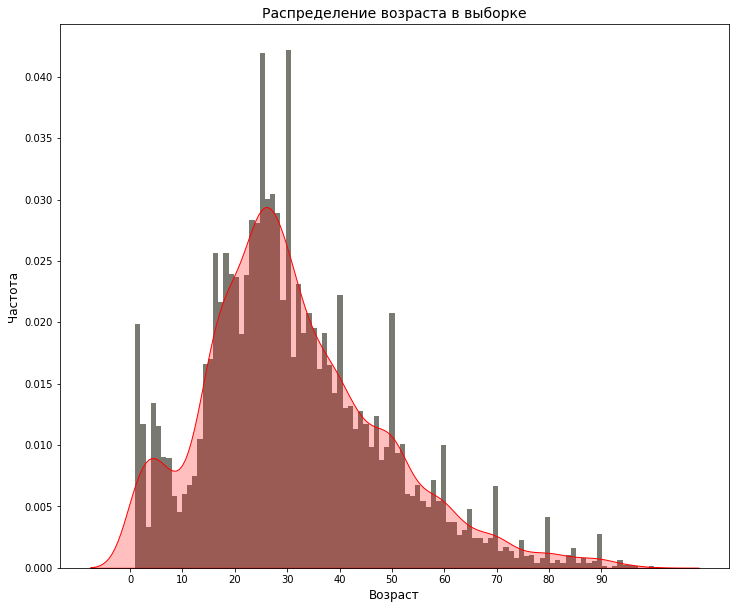

count    7591.000000
mean       31.201159
std        17.145060
min         1.000000
25%        20.000000
50%        29.000000
75%        41.000000
max       100.000000
Name: real_age, dtype: float64

In [32]:
labels['real_age'].hist(bins=100, grid=False, figsize=(12,10), density=True)
plt.title('Распределение возраста в выборке', fontsize=14)
sns.distplot(labels['real_age'], rug=False, kde_kws={'shade':True, 'color':'r'}, bins=100)
plt.xlabel('Возраст', fontsize=12)
plt.xticks(np.arange(0, 100, step=10)) 
plt.ylabel('Частота', fontsize=12)
plt.show()
labels['real_age'].describe()

* В данных представлены самые разные возраста от 1 года до 100 лет.
* Медиана на 29 годах.
* Заметны пики для разных возрастных групп. Наибольшие значения в группах находятся у круглых дат, как 30,40,50 и т.д. Таким образом, большую часть возрастных категорий будут определяться вокруг круглых дат.
* Тем не менее, есть данные и вокруг круглых дат. 
* Данные выглядят правдоподобно.
* Однако значений около 90-100 лет крайне мало и возможно будет недостаточно для обучения модели.
* Далее импортируем данные с изображениями.

In [33]:
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='../input/appa-real-face-cropped/final_files/final_files',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345) 

Found 7591 validated image filenames.


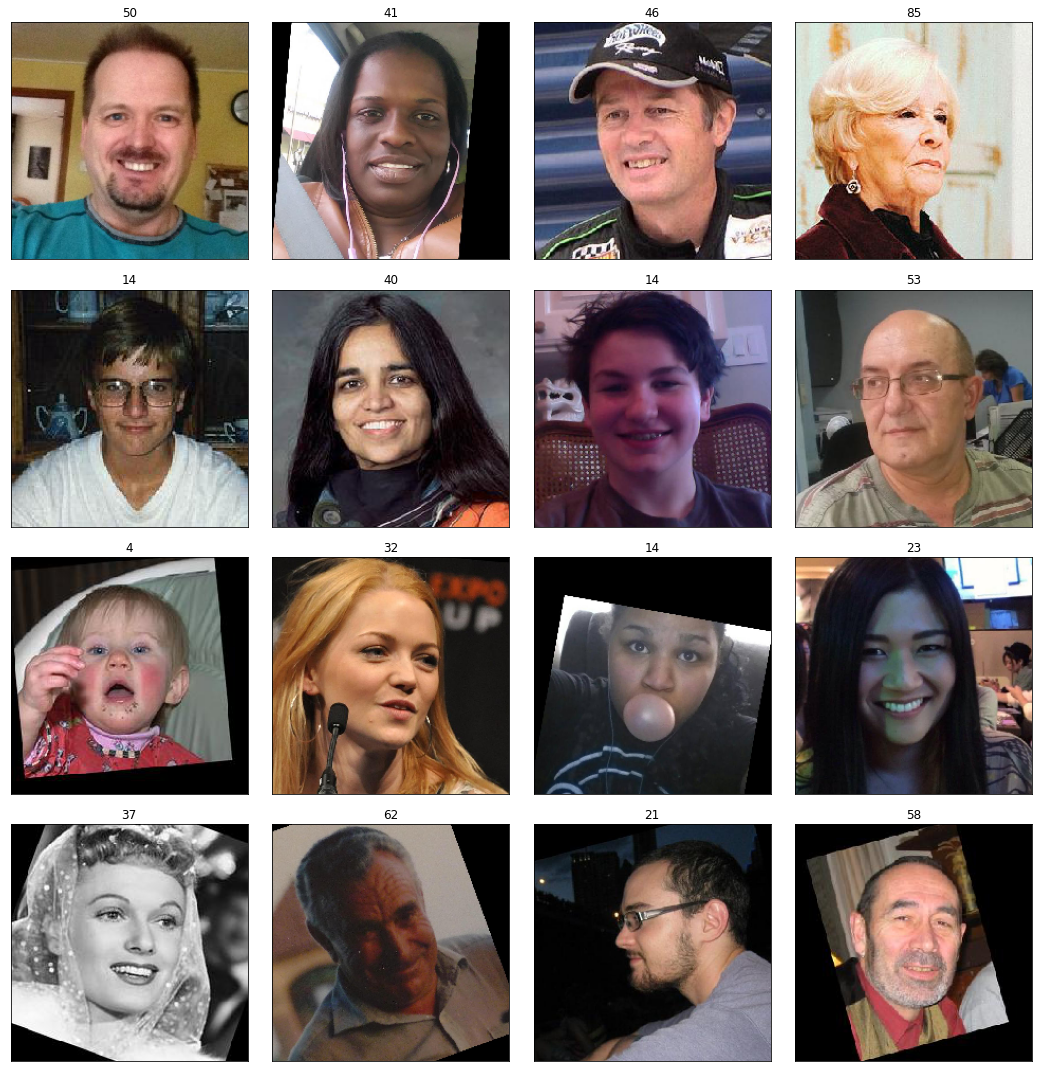

In [34]:
#Выведим значения изображений из первого батча тренировочной выборки
features, target = next(train_gen_flow)

# Выведем 16 рандомных изображений из первого батча тренировочной выборки
fig = plt.figure(figsize=(15,15))
for i in range(16):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(features[i])
    plt.title(f'{target[i]}')
  # для компактности удаляем оси и прижимаем изображения друг к другу
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

### Вывод

* Возрасты на рандомных 16 фото соответствуют изображениям.
* Представлены как цветные, так и чёрно-белые фото.
* Фото разного качества, некоторые фотографии имеют повернутый угол - центрированы.

## Построение и обучение модели

Построим функции для загрузки данных, построения и обучения модели.

In [35]:
# Загрузим данные тренировочного датасета
def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')
    train_datagen = ImageDataGenerator(
    validation_split=0.25,
    rescale=1./255,
    horizontal_flip=True, # Добавим аугментацию
    vertical_flip=True)
  
    train_datagen_flow = train_datagen.flow_from_dataframe(
        dataframe= labels,
        directory= path + '/final_files/final_files',
        x_col='file_name',
        y_col='real_age',
        subset='training',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345)
    return train_datagen_flow
 
# Загрузим данные тестового датасета
def load_test(path):
    test_datagen = ImageDataGenerator(validation_split=0.25,
        rescale=1/255.)
    test_datagen_flow = test_datagen.flow_from_dataframe(
        dataframe= labels,
        directory= path + '/final_files/final_files',
        x_col='file_name',
        y_col='real_age',
        subset='validation',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345)
    return test_datagen_flow
 
# Построим модель
def create_model(input_shape):
    backbone = ResNet50(input_shape=(224, 224, 3),
    weights='imagenet', 
                    include_top=False)
 
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1, activation='relu')) 
    optimizer = Adam(lr=0.0001)
    model.compile(optimizer=optimizer, loss='mean_squared_error', 
               metrics=['mae'])
    return model
 
# Построим функцию для обучения модели.
def train_model(model, train_data, test_data, batch_size=None, epochs=12,
               steps_per_epoch=None, validation_steps=None):
 
    model.fit(train_data, 
              validation_data=test_data,
              batch_size=batch_size, 
              epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2, 
              shuffle=True)
 
    return model

In [36]:
# Получим тренировочные и тестовые данные
path = '../input/appa-real-face-cropped/'
train_data = load_train(path)
test_data = load_test(path)

Found 5694 validated image filenames.
Found 1897 validated image filenames.


In [11]:
# Создадим модель
model = create_model(input_shape = (224, 224, 3))

2022-07-21 20:34:40.879287: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-21 20:34:40.883624: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-21 20:34:40.884350: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-21 20:34:40.885445: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

94781440/94765736 [==============================] - 1s 0us/step


In [12]:
# Обучим модель на 10 эпохах
history = train_model(model, train_data, test_data, batch_size=None, epochs=10,
               steps_per_epoch=None, validation_steps=None)

2022-07-21 20:34:58.112943: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10


2022-07-21 20:35:07.686569: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


178/178 - 83s - loss: 264.7407 - mae: 11.7924 - val_loss: 633.9828 - val_mae: 20.2071
Epoch 2/10
178/178 - 52s - loss: 105.2927 - mae: 7.8193 - val_loss: 571.4338 - val_mae: 18.8780
Epoch 3/10
178/178 - 51s - loss: 79.2601 - mae: 6.6860 - val_loss: 415.9647 - val_mae: 15.3168
Epoch 4/10
178/178 - 52s - loss: 67.2991 - mae: 6.2216 - val_loss: 240.8101 - val_mae: 11.7483
Epoch 5/10
178/178 - 52s - loss: 55.6002 - mae: 5.6771 - val_loss: 98.5862 - val_mae: 7.3699
Epoch 6/10
178/178 - 51s - loss: 48.8881 - mae: 5.2853 - val_loss: 99.7503 - val_mae: 7.4370
Epoch 7/10
178/178 - 51s - loss: 44.3981 - mae: 5.0973 - val_loss: 81.9809 - val_mae: 6.9015
Epoch 8/10
178/178 - 52s - loss: 38.8276 - mae: 4.7395 - val_loss: 74.1331 - val_mae: 6.3786
Epoch 9/10
178/178 - 52s - loss: 32.2542 - mae: 4.3277 - val_loss: 90.5770 - val_mae: 7.0939
Epoch 10/10
178/178 - 51s - loss: 32.2921 - mae: 4.3128 - val_loss: 75.1320 - val_mae: 6.4211


In [13]:
# Сохраним модель
model.save("rps.h5")

In [23]:
# Загрузим обученную модель
model = keras.models.load_model('../input/d/podturkinalex/appa-real-face-cropped/rps (3).h5')

2022-07-21 21:10:58.103393: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [37]:
# Получим батч из 32 фотографий и возрастов из тестовой выборки
features_test, target_test = next(test_data) 

In [127]:
# Получим предсказание модели
predicted = model.predict(features_test)

In [176]:
# Посмотрим на реальный и предсказанный возраст 32 людей из батча 
real_age = pd.DataFrame(target_test, columns=['Реальный возраст'])
predicted_age = pd.DataFrame(round(pd.DataFrame(predicted, columns=['Предсказаный возраст'])).astype('int'))

real_age.merge(predicted_age, how='inner', left_index=True, right_index=True)

,Реальный возраст,Предсказаный возраст
0,16,16
1,14,22
2,40,35
3,29,34
4,30,25
5,50,51
6,38,29
7,16,25
8,32,29
9,41,31


* Видны расхождения в предсказании модели.
* Посмотрим на сами фотографии людей.

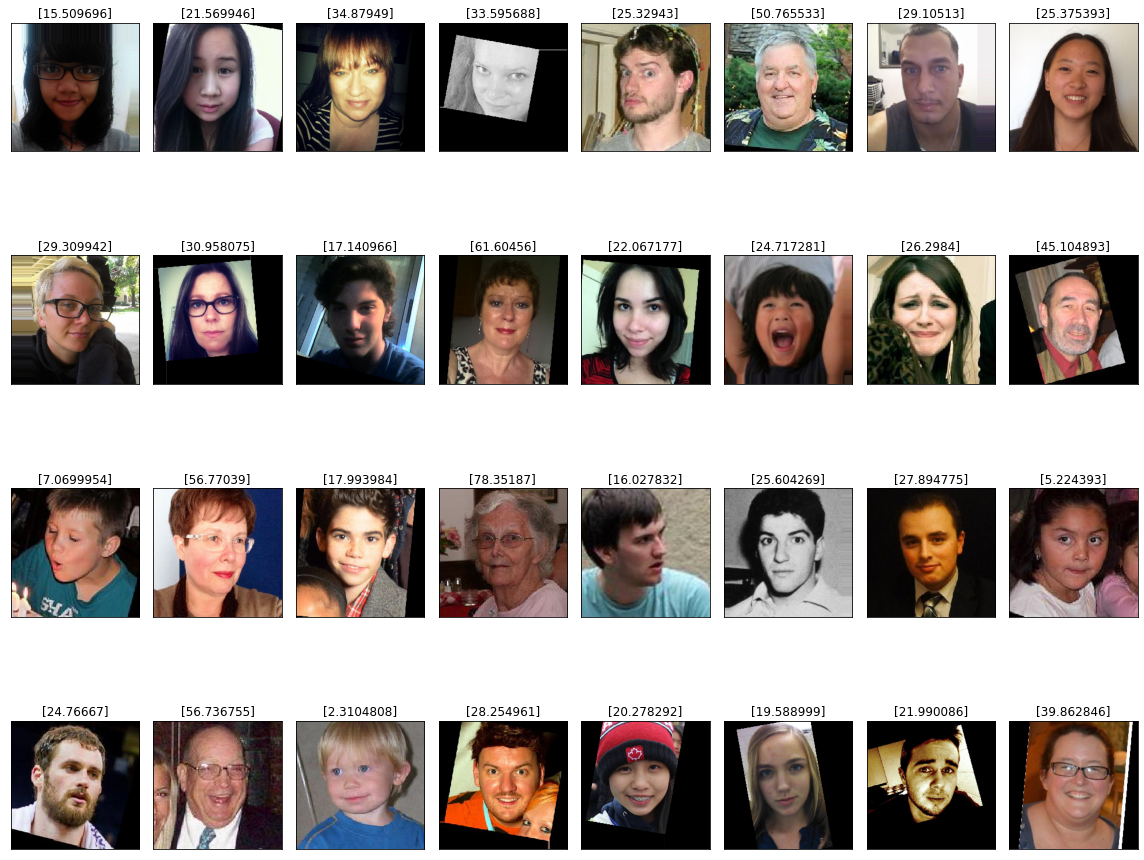

In [175]:
# Посмотрим на предсказанный возраст на фотографиях
fig = plt.figure(figsize=(16,16))
for i in range(len(model.predict(features_test))):
    fig.add_subplot(4, 8, i+1)
    plt.imshow(features_test[i])
    plt.title(f'{model.predict(features_test)[i]}')
  # для компактности удаляем оси и прижимаем изображения друг к другу
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

* Можно заметить, что модель имеет расхождения для возрастных групп, которые реже представлены в выборке.
* Однако для 20-летних возраст предсказывается довольно точно.

# Вывод

* Построена модель ResNet50 на предобученной выборке `imagenet`. Был добавлен один дополнительный слой `model.add(Dense(64, activation='relu'))` для повышения точности предсказания модели.
* Точность предсказания тестовой выборки составила, оцененая по метрике `MAE` составила 6.42, что лучше ожидаемой метрики заказчика в 8.
* Таким образом, построенная модель позволяет предсказать возраст с точностью ±6,4 года. 